# CHAPTER 19 - Learning 

### Instructor: Brandon Haworth
#### Notebook Credit: George Tzanetakis
Jupyter Notebooks you encounter during the course were largely developed by Prof. Tzanetakis from a previous iteration of this course. I've since changed/developed them where necessary for my own iterations of CSC 421.

## WORKPLAN 

The section number is based on the 4th edition of the AIMA textbook and is the suggested
reading for this week. Each list entry provides just the additional sections. For example, the Expected reading includes the sections listed under Basic as well as the sections listed under Expected. Some additional readings are suggested for Advanced.
In the 4th edition of the AIMA textbook, this notebook corresponds to Chapter 19. 

1. Basic: Sections **19.1**, **19.2**, and **Summary**
2. Expected: Same as Basic plus **19.3**, **19.6**, **19.7**
3. Advanced: All the chapter including bibliographical and historical notes 






# Forms of learning  

An agent is **learning** if it improves its performance on future tasks after making observations about the world. 
In this chapter, we focus on a simple type of learning problem, which is given a collection of input-output pairs, and learn 
a function that predicts the output for new inputs. Even though at first glance this seems like a simple learning problem, 
it has a large number of applications. 

## Feedback to learn from 

There are *types of feedback* that determine the three main types of learning: 

* **Unsupervised learning:** The agent learns patterns in the input without any explicit feedback. The most common example of unsupervised learning is **clustering**
* **Reinforcement learning:** The agent learns from a series of reinforcements (rewards and punishments).
* **Supervised learning:** The agent observes some example input/output pairs and learns a function that maps the input to the output. 




In [28]:
import numpy as np
mu = 3.0 
sigma = 0.2 
s = np.random.normal(mu, sigma, 10)
print(s)

[3.46352689 3.24606542 3.46405005 2.79227813 3.00459622 2.89305973
 3.24723249 2.58538071 2.7268959  2.49271665]


In [29]:
samples = np.random.normal(mu, sigma, 10000)
print(len(samples))

10000



# Simple binary classification example

In this notebook, I will show a very simple example of this idea. Hopefully, this will give you some general intuition about this approach. Then you can review the specific book examples that are more complicated (learning Gaussian mixtures, Bayesian networks with hidden variables, and learning HMM parameters). We will end by showing the general mathematical notation. 



Let's consider a simple binary classification problem with one continuous attribute. For example, this could be classifying whether someone is a professional basketball player or not based on their height. We can generate some synthetic data for this problem by simply sampling two Gaussian distributions. Let's say that professional basketball players have an average height of 190cm and the average height of other people is 175cm. For simplicity, we will consider that they both have a standard deviation of 10cm. 

In [30]:
import numpy as np

# generate twenty samples of each class 
bball_samples = np.random.normal(190, 10, 20)
other_samples = np.random.normal(175, 10, 20)
print(bball_samples)
print(other_samples)

[194.94984328 197.24994801 190.23502051 184.81399103 191.22224789
 188.5200175  207.57566765 187.69710687 189.55033313 209.4759324
 187.32652298 188.03479713 195.25846457 188.10840383 196.62558338
 193.93948355 196.16692242 200.90557206 179.85376134 195.90502457]
[176.84794012 169.78714538 171.25397576 175.04729981 177.49471383
 172.16867371 172.27073628 173.5910691  176.87883952 179.40791355
 174.33593088 192.39445129 178.6937808  167.14431239 152.09985535
 168.11283828 184.8194546  159.53580352 179.55610209 179.53966455]


In [31]:
# generate 1000 samples of each class and plot histogram 

bball_mean_height = 190 
other_mean_height = 175 
bball_samples = np.random.normal(bball_mean_height, 10, 1000)
other_samples = np.random.normal(other_mean_height, 10, 1000)

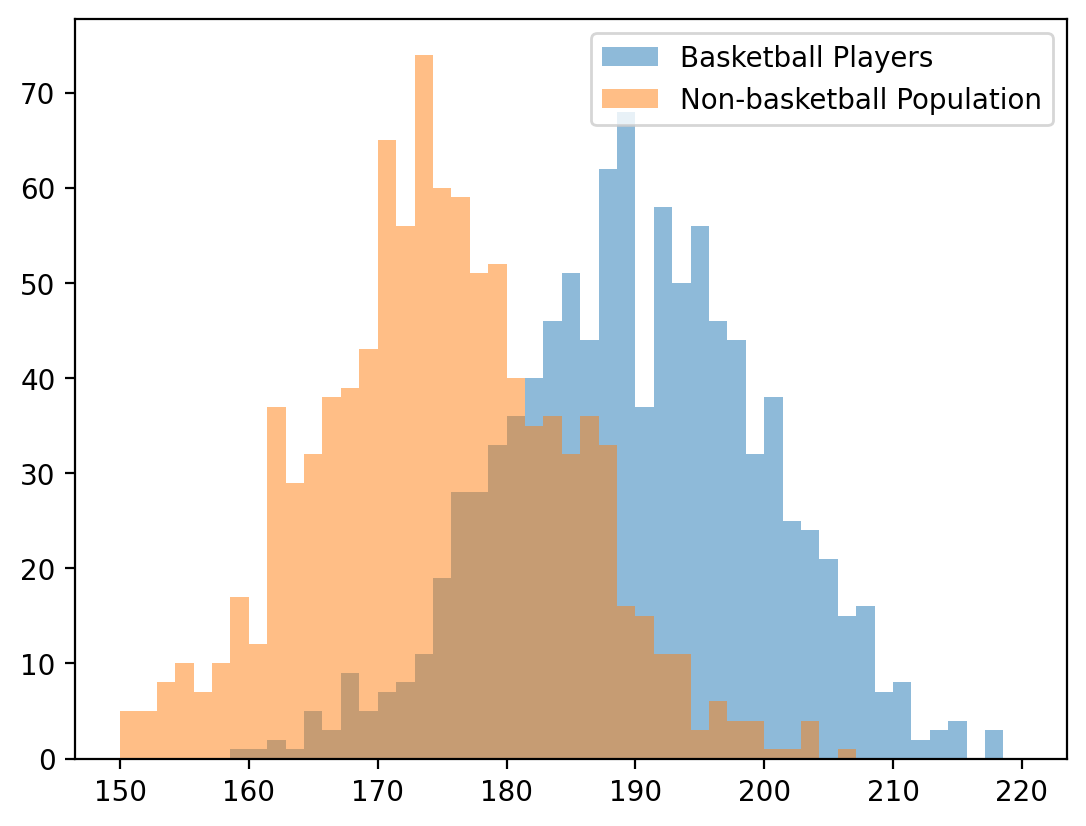

In [32]:
from matplotlib import pyplot
bins = np.linspace(150, 220, 50)
pyplot.hist(bball_samples, bins, alpha=0.5, label='Basketball Players')
pyplot.hist(other_samples, bins, alpha=0.5, label='Non-basketball Population')
pyplot.legend(loc='upper right')
pyplot.show()

You can clearly see in the histogram the height distribution and overlap. You can also see that there is an equal number of instances for each class and that the standard deviation is the same.

Now, suppose that you are just given the nba_samples and other_samples and told that these are labeled samples for training a Naive Bayes classifier. You also know that they both have a standard deviation of 10cm, so we will keep that. In this case, the only parameter we are trying to estimate is the mean of each class. So $\theta = (\mu_{nba}, \mu_{other})$.

Given this data, the maximum likelihood estimate for the means is easily obtained by taking the statistical mean of the samples.

In [33]:
mu_bball = np.mean(bball_samples)
mu_other = np.mean(other_samples)
print(mu_bball, mu_other)

190.14472867860914 174.9104247037314


Now that we have "learned" a model we can use it to predict. Suppose you are given a test height - let's say 183cm. You can calcuate the $P(183 \vert nba)$ and $P(183 \vert other)$ by using the corresponding probability density functions characterized by $\mu_{nba}$ and $\sigma = 10$ and $\mu_{other}$ and $\sigma = 10$. 

In [34]:
from scipy.stats import norm

test_height = 200

p_bball = norm(mu_bball, 10).pdf(test_height) # probability density function of a normal continuous random variable.
p_other = norm(mu_other, 10).pdf(test_height)
print(p_bball, p_other)

if (p_bball > p_other): 
    print(str(test_height) + " is more likely a professional basketball player")
else: 
    print(str(test_height) + " is more likely NOT a professional basketball player")


0.024547248944942427 0.0017139449641245103
200 is more likely a professional basketball player


## Learning Decision Trees 




A **decision tree** represents a function that takes as input a vector of attribute values and returns a **decision** - a single output value. The input and output values can be discrete or continuous. To make things simple we will focus initially on discrete attributes and a single binary output (true or false)(positive or negative). 

A decision tree makes a decision by performing a sequence of tests. Each node in the tree corresponds to a test of the value of one of the input attributes $A_i$, and the branches from the node are labelled with the possible values of the attribute. Each leaf node in the tree specifies a value to be returned by the function. 

One way to think of a decision tree is through propositional logic. The goal attribute is true if and only if the input attributes satisfy one of the paths leading to a leaf with value *true*: 

$$
Goal <=> (Path_{1} \lor Path_{2} \lor \dots)
$$

Each path is a conjunction of attribute-value tests required to follow the path. 

## Inducing decision trees from examples


An instance or example that can be used to "train" a decision tree consists of an $(\bf{x},y)$ pair, where $x$ is a vector of values for the input attributes, and $y$ is a single output value. This is called the target (or goal) attribute and corresponds to whether $WillWait$ is $true$ or $false$. 

Note that this set of variables leads to 9216 possible combinations, $2^6 \times 3^2 \times 4^2 = 9216$. Yet we only have 12 samples and we want to know, via induction, our best guess at any of the other possible combinations given just this small amount of evidence.

<img src="images/decision_tree_attributes.png" width="100%"/>


<img src="images/decision_tree.png" width="100%"/>


Ideally, we would want the smallest possible tree that is consistent with the examples. However, this is an intractable problem as there are $2^{2^{n}}$ trees to consider. We can do a decent job using a greedy divide-and-conquer strategy. 

1. Choose a "good" attribute to split
2. If all examples after a split are positive (or negative), then return the corresponding classification 
3. Create two subproblems based on the split
4. Recursively repeat the process until there are no attributes left to split 
5. When there are both positive and negative examples, use plurality to make a decision


<img src="images/decision_tree_attribute_splits.png" width="100%"/>

<img src="images/decision_tree_learning_algorithm.png" width="50%"/>

<img src="images/induced_decision_tree.png" width="100%"/>


## Choosing attribute tests

We need a formal measure of "fairly good" and "really useless" to implement the $IMPORTANCE$ function. We will use the notation of information gain, which is defined in terms of **entropy**, the fundamental quantity in information theory. 

**Entropy** of a random variable: 

$$ 
H(V) = \sum_{k} P(v_k) \log_{2} \frac{1}{P(v_k)} = - \sum_{k} P(v_k) \log_2P(v_k)
$$

For example, the entropy of a fair coin is 1 bit: 
$$
H(Fair) = -(0.5 \log_2 0.5 + 0.5 \log_2 0.5) = 1
$$

If *Loaded* is a random coin with a $0.99$ probability of being Heads and a $0.01$ probability of being a Tails, we get: 

$$
H(Loaded) = -(0.99 \log_2 0.99 + 0.01 \log_2 0.01) \approx 0.08 bits
$$

Let's define $B(q)$ as the entropy of a Boolean random variable that is true with probability $q$: 
$$
B(q) = -\left (q \log_2 q + (1-q) \log_2 (1 - q)\right)
$$

If the training set contains $p$ positive examples and $n$ negative examples, then the entropy of the target attribute on the whole set is: 
$$ 
H(Goal) = B\left(\frac{p}{p+n}\right)
$$

For example, the restaurant training set has $p=n=6$, so the corresponding entropy is $B(0.5) = 1$. A test on a single attribute(feature) might give us only part of this 1 bit. We can measure exactly how much by looking at the entropy remaining after the attribute test. 
Suppose that an attribute A with $d$ distinct values divides the training set $E$ into subsets $E_1, \dots, E_d$. Each subset $E_k$ has $p_k$ positive examples and $n_k$ negative examples, so if we go along that branch, we need an additional $B(p_k / (p_k +n_k))$ bits of information to answer the question. A randomly chosen example from the training set has the kth value for the attribute with probability $(p_k + n_k)/(p + n)$, so the expected entropy remaining after testing attribute $A$ is 
$$ 
Remainder(A) = \sum_{k=1}^{d} \frac{(p_k + n_k)}{p+n} B\left(\frac{p_k}{p_k+n_k}\right)
$$

The **information gain** from the attribute test on $A$ is the expected reduction in entropy: 
$$ 
Gain(A) = B\left(\frac{p}{p+n}\right) - Remainder(A) 
$$

For example, consider the attributes from our example we have: 

$$ 
Gain(Patrons) = 1 - \left[\frac{2}{12} B\left(\frac{0}{2}\right) + \frac{4}{12}B\left(\frac{4}{4}\right)+ \frac{6}{12}B\left(\frac{2}{6}\right)\right] \approx 0.541 bits
$$
$$ 
Gain(Type) = 1 - \left[\frac{2}{12} B\left(\frac{1}{2}\right) + \frac{2}{12}B\left(\frac{1}{2}\right)+ \frac{4}{12}B\left(\frac{2}{4}\right) + \frac{4}{12}B\left(\frac{2}{4}\right)\right] = 0  bits
$$


### Additional topics 

* Overfitting
* Decision tree pruning
* Significance test
* Early stopping
* Missing data
* Multi-valued attributes
* Continuous and integer-valued input attributes
* Continuous-valued output attributes

One **important property** of decision trees is that it is possible for a human to understand the reason for the output of the learning algorithm. This can be a **legal requirement** for financial decisions and is not the case in other learned representations, such as neural networks. 

In [35]:

import pandas as pd 
import numpy as np

data = np.array([['Yes', 'No', 'No', 'Yes', 'Some', '3D', 'No', 'Yes', 'French', '0_10', 'Yes'], 
                 ['Yes', 'No', 'No', 'Yes', 'Full', '1D', 'No', 'No', 'Thai', '30_60', 'No'],
                 ['No' , 'Yes', 'No', 'No', 'Some', '1D', 'No', 'No',  'Burger', '0_10', 'Yes'],
                 ['Yes' ,'No', 'Yes', 'Yes', 'Full', '1D', 'Yes', 'No', 'Thai', '10_30', 'Yes'],
                 ['Yes', 'No', 'Yes' ,'No' ,'Full', '3D', 'No', 'Yes', 'French', '>60', 'No'],
                 ['No',  'Yes', 'No', 'Yes', 'Some','2D', 'Yes', 'Yes', 'Italian', '0_10', 'Yes'], 
                 ['No', 'Yes' , 'No' , 'No' , 'None' ,'1D', 'Yes', 'No', 'Burger', '0_10', 'No'], 
                 ['No', 'No', 'No', 'Yes', 'Some', '2D', 'Yes', 'Yes', 'Thai', '0_10', 'Yes'], 
                 ['No', 'Yes','Yes', 'No', 'Full', '1D', 'Yes', 'No', 'Burger', '>60', 'No'],
                 ['Yes', 'Yes', 'Yes', 'Yes', 'Full', '3D', 'No', 'Yes', 'Italian', '10_30', 'No'],
                 ['No', 'No', 'No', 'No', 'None', '1D', 'No', 'No', 'Thai', '0_10', 'No'],
                 ['Yes','Yes','Yes','Yes','Full', '1D', 'No', 'No', 'Burger','30_60', 'Yes']
                ]
               )

feature_names = ['Alt', 'Bar', 'Fri', 'Hun', 'Pat', 'Price', 'Rain', 'Res', 'Type', 'Est'] 
target_name   = 'WillWait'
df = pd.DataFrame(data, columns = feature_names + [target_name])
print(df)


    Alt  Bar  Fri  Hun   Pat Price Rain  Res     Type    Est WillWait
0   Yes   No   No  Yes  Some    3D   No  Yes   French   0_10      Yes
1   Yes   No   No  Yes  Full    1D   No   No     Thai  30_60       No
2    No  Yes   No   No  Some    1D   No   No   Burger   0_10      Yes
3   Yes   No  Yes  Yes  Full    1D  Yes   No     Thai  10_30      Yes
4   Yes   No  Yes   No  Full    3D   No  Yes   French    >60       No
5    No  Yes   No  Yes  Some    2D  Yes  Yes  Italian   0_10      Yes
6    No  Yes   No   No  None    1D  Yes   No   Burger   0_10       No
7    No   No   No  Yes  Some    2D  Yes  Yes     Thai   0_10      Yes
8    No  Yes  Yes   No  Full    1D  Yes   No   Burger    >60       No
9   Yes  Yes  Yes  Yes  Full    3D   No  Yes  Italian  10_30       No
10   No   No   No   No  None    1D   No   No     Thai   0_10       No
11  Yes  Yes  Yes  Yes  Full    1D   No   No   Burger  30_60      Yes


In [36]:
from sklearn import tree
from sklearn import preprocessing

categorical_features = df[feature_names]
orig_target = df[target_name]
print(categorical_features)
print(orig_target)
numerical_features = pd.DataFrame()
# Encode categorical variables
for f in feature_names: 
    numerical_features[f] = categorical_features[f].astype("category").cat.codes
target = orig_target.astype("category").cat.codes
print(numerical_features)
print(target)


    Alt  Bar  Fri  Hun   Pat Price Rain  Res     Type    Est
0   Yes   No   No  Yes  Some    3D   No  Yes   French   0_10
1   Yes   No   No  Yes  Full    1D   No   No     Thai  30_60
2    No  Yes   No   No  Some    1D   No   No   Burger   0_10
3   Yes   No  Yes  Yes  Full    1D  Yes   No     Thai  10_30
4   Yes   No  Yes   No  Full    3D   No  Yes   French    >60
5    No  Yes   No  Yes  Some    2D  Yes  Yes  Italian   0_10
6    No  Yes   No   No  None    1D  Yes   No   Burger   0_10
7    No   No   No  Yes  Some    2D  Yes  Yes     Thai   0_10
8    No  Yes  Yes   No  Full    1D  Yes   No   Burger    >60
9   Yes  Yes  Yes  Yes  Full    3D   No  Yes  Italian  10_30
10   No   No   No   No  None    1D   No   No     Thai   0_10
11  Yes  Yes  Yes  Yes  Full    1D   No   No   Burger  30_60
0     Yes
1      No
2     Yes
3     Yes
4      No
5     Yes
6      No
7     Yes
8      No
9      No
10     No
11    Yes
Name: WillWait, dtype: object
    Alt  Bar  Fri  Hun  Pat  Price  Rain  Res  Type  Est


In [37]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(numerical_features[feature_names].values, target.values)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.6, 0.9, 'x[4] <= 1.5\ngini = 0.5\nsamples = 12\nvalue = [6, 6]'),
 Text(0.4, 0.7, 'x[3] <= 0.5\ngini = 0.375\nsamples = 8\nvalue = [6, 2]'),
 Text(0.5, 0.8, 'True  '),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.6, 0.5, 'x[5] <= 1.0\ngini = 0.5\nsamples = 4\nvalue = [2, 2]'),
 Text(0.4, 0.3, 'x[2] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.2, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.6, 0.1, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.8, 0.3, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.8, 0.7, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.7, 0.8, '  False')]

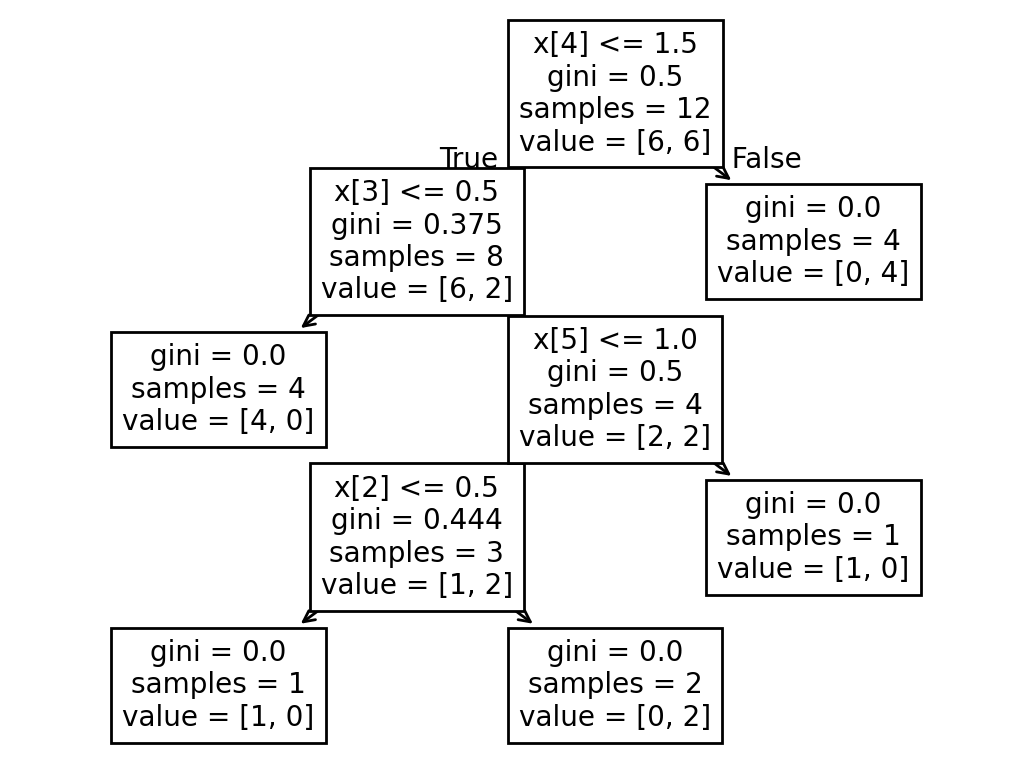

In [38]:
tree.plot_tree(clf)

In [39]:
import dtreeviz
import matplotlib.font_manager

In [40]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

viz_model = dtreeviz.model(clf,
                           X_train=numerical_features[feature_names], y_train=target,
                           feature_names=feature_names,
                           target_name=target_name, class_names=["Yes", "No"])

In [42]:
viz_model.view(scale=2.0)


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

## Evaluating and choosing the best hypothesis 


When learning a machine learning model, we want the model to perform "well" on "future data," not just the data that it was trained on. In order to be more precise, we need to define what we mean by "well" and "future data". To do this, we will make the **stationarity assumption**: that there is a probability distribution over the examples that does not change over time. Each example data point is a random variable $E_j$ whose observed value $e_j = (x_j, y_j)$ is sampled from that distribution and is independent of the previous examples: 
$$ 
{\bf P}(E_j | E_{j-1}, E_{j-2}, \dots) = {\bf P}(E_j)
$$, 
and each example has an identical prior probability distribution: 
$$
{\bf P}(E_j) = {\bf P}(E_{j-1}) = {\bf P}(E_{j-2}) = \dots 
$$

Examples that satisfy these assumptions are called independent and identically distributed or **i.i.d**. 

### Error rate 

The **error rate** of a hypothesis/model is the proportion of mistakes it makes - the proportion of 
times that the output of the model $h(x) \neq y$ for an $(x,y)$ example. The key observation is that because a hypothesis $h$ has a low error on the training set this does not mean that it will generalize well. So in order to get an accurate idea of how well a particular model does, we need to 
test it on examples it has not seen yet (i.e. they have not been used for training). 

The simplest approach, which is called **Hold-out cross-validation** is to randomly split the available labelled data into a training set from which the learning algorithm produces a hypothesis $h$ and a test set on which the accuracy of $h$ is evaluated. There are two challenges with this approach: not all data is used for training and it is unclear how much to use for training and how much to use for testing. 

A more sophisticated and pretty much standard approach in machine learning is what is called **k-fold cross-validation**. The labelled data is split into $k$ equal subsets (the folds). We then perform $k$ rounds of learning. In each round, one fold is held out as a test set and the remaining $k-1$ folds are used for training. 

**Peeking** occurs when adjustments are made to an algorithm based on how it is doing on the test set error rate. Information about the test set is leaked into the learning algorithm. To avoid this a common practice is to keep a test set completely separate and not evaluate it until all learning is complete. In order to optimize the model/learning algorithm, instead a **validation** set can be used. 



## Regression

Regression refers to the problem of predicting continuous values, whereas in classification, we predict discrete categorical values. Ordinal classification is a special case that is somewhat between where there are discrete values, but there is an implied ordering of them (for example, short, average, tall). Ordinal classification can be treated as a classification problem, in which case the ordering is ignored or as a regression problem, in which case threshold values between the classes need to be established.

## Univariate Linear Regression 

A very basic operation to consider is "fitting" a straight line. A univariate linear function with input $x$ and output $y$ has the form $y = w_1 x + w_o$ where $w_o$ and $w_1$ are real-valued coefficients to be learned. We use a vector $w$ instead of the more familiar $a$ and $b$ for reasons that will become apparent later. The vector $w$ is called the weights vector. So we have: 

$$ 
h_{\bf w}(x) = w_1 x + w_0
$$ 

Given a set of $N$ training points on the plane, our task is to find the line that best fits these data points. This is called *linear regression*. We can use a squared loss function $L_2$ summed over all the training examples: 

$$ 
Loss(h_{\bf w}) = \sum_{j=1}^{N} L_{2} (y_j, h_{\bf w}(x_j))) = \sum_{j=1}^{N}(y_j - h_{\bf w}(x_j))^2 = \sum_{j=1}^{N} (y_j - (w_{1} x_j + w_0))^2
$$




We would like to find $w^{*} = \text{argmin}_{\bf w} Loss(h_{\bf w})$ 




Setting the partial derivatives to $0$ with respect to $w_0$ and $w_1$ we can find the unique solution for $w_1$ and $w_0$. 

Many forms of learning involve adjusting weights to minimize a loss, so we will look at linear regression from that perspective. One can think of the **weight space**, in linear regression a two-dimensional space, but in general a high-dimensional space, as the space defined by all possible settings of the weights. For linear regression, there is a unique minimum and we can find it analytically. In most other cases of machine learning, there is no closed-form solution and no single global minimum. 

Such problems can be addressed by a hill-climbing algorithm that follows the **gradient** of the function to be optimized. This is called **gradient descent**. The algorithm starts at any point in the weight space and then moves into a neighbouring point that is downhill, repeating until we converge on the minimum possible loss. The weight update for gradient descent is: 

$$
w_i \leftarrow w_i - \alpha \frac{\partial }{\partial w_{i}} Loss({\bf w})
$$

The parameter $\alpha$, is called the **learning rate**. It can be a fixed constant, or it can decay over time as the learning process proceeds. For $N$ training examples, we want to minimize the sum of the individual losses for each example. The derivative of the sum is the sum of the derivatives so we have: 

$$
w_0 \leftarrow w_{0} + \alpha \sum_{j} (y_j - h_{\bf w}(x_j))
$$

$$ 
w_1 \rightarrow w_{1} + \alpha \sum_{j} (y_j - h_{\bf w}(x_j)) \times x_j 
$$ 

The updates constitute the **batch gradient descent** rule. An alternative is **stochastic gradient descent** where we consider only a random single training point at a time and take an update step. 

It is straightforward to extend to **multi-variate linear regression**. 

$$
h_{\bf w}({\bf x_j}) = w_{0} + w_{1}x_{j,1} + \dots + w_n x_{j,n} = w_{0} + \sum_{j}{w_{i}x_{j,i}}
$$




A common trick used to make the notation more compact is to invent a dummy input attribute $x_{j,0}$ which is always equal to $1$ and is multiplied by the intercept weight $\omega_0$. Then $h$ is simply the dot-product of the weights and the input vector (or equivalently, the matrix product of the transpose of the weights and the input vector): 

$$
h_{w}({\bf x_{j}}) = {\bf w} \cdot {\bf x}_{j} = {\bf w}^{T} {\bf x}_{j} 
$$


The best vector of weight, ${\bf w}^{*}$, minimizes squarred-error loss over the examples: 

$$
{\bf w}{*} = \text{argmin}_{\bf w} \sum_{j} L_{2}(y_j, {\bf w} \cdot {\bf x_j})
$$

## Discriminative Classification
**Main Idea**: Instead of trying to model all the training data using a probability density function, just consider the linear decision boundary and focus on finding an optimal one. This directly solves the classification problem (at least for the binary case) rather than training it to the potentially more complex problem of fitting a distribution to a set of samples.

### Linear classification with a hard-threshold 


A **decision boundary** is a line (or surface) that separates two classes. A linear decision boundary is called a **linear separator**, and data that admits such a separator is called **linearly separable**. The classification hypothesis can be written as: 

 
$h_{\bf w} ({\bf x}) = 1$ if ${\bf w} \cdot {\bf x} \geq 0$  
and $0$ otherwise. 

One can think of this process as passing the output of the linear function ${\bf w} \cdot {\bf x}$ through a **threshold function**. 


Line equation (assume 2D first):
$$ 
  w_2 x_2 + w_1 x_1 + b = 0
$$

* All points (x1, x2 ) lying on the line make the equation true.
*  The line separates the plane into two half-planes.
*  The points (x1, x2 ) in one half-plane give us an inequality with respect to 0, which has the same direction for each of the points in the half-plane.
* Fact: The points (x1, x2 ) in the other half-plane give us the reverse inequality with respect to 0.

The linear decision boundary can be generalized to a high-dimensional hyperplane 

$$
g({\bf x}) = {\bf w}^T {\bf x} + w_0 = 0,
$$
where $w = [w_1,w_2,\dots,w_l]^T$ is the weight vector and $w_0$ is the
threshold.


### Perceptron Learning Rule 


Simple weight update scheme that converges to a solution (linear separator) that classifies the data perfectly, provided the data is linearly separable. For a single example $({\bf x}, y)$ we have: 

$$ 
w_i \leftarrow w_i + \alpha (y - h_{\bf w} ({\bf x})) \times x_i
$$

If the output is correct the weights are left unchanged. If $y$ (the ground truth) is $1$ and the output $h_{\bf w}(\bf x)$ is $0$ then $w_i$ is increased. If $y$ is $0$ and the output is $1$, then $w_i$ is decreased. 



### Logistic Regression

In many cases, we are not just interested in a hard classification decision but would like to have a probability for each predicted class, similar to how we could get one from the Naive Bayes classifier. This is typically achieved by "softening" the threshold function and making it continuous and differentiable. 

Let's start with the logistic function (also known as sigmoid) is defined as:
<p style="text-align:center;">
<table>
    <tr>
        <td>
        $$
        Logistic(z) = \frac{1}{1 + e^{-z}}
        $$
        </td>
        <td><img src="images/Logistic-curve.png" width="35%"/></td>
    </tr>
</table>
</p>


The logisitic function will turn any number into a value between $0$ and $1$. The secret sauce here is that we let $z$ be your standard linear function $y = \omega_0 + \omega_1 x_1 + \omega_2 x_2 + ... + \omega_n x_n$

This function can be interpreted as a probability

$$
p(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ... + \omega_n x_n) = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ... + \omega_n x_n)}}
$$
which we can rewrite using our dot product notation and trick as above.
$$
p(\bf{w}\cdot\bf{x}) = \frac{1}{1 + e^{-\bf{w}\cdot\bf{x}}}
$$
We can use this as our separator function like in the linear classification above.
$$
h_{\bf w} = Logistic(\bf{w}\cdot\bf{x}) = \frac{1}{1 + e^{-\bf{w}\cdot\bf{x}}}
$$

There is no closed form for logistic regression, but gradient descent works in a straightforward way because the logistic function is easy to differentiate. ALl you need to do is differentiate the squared loss function with our new $h_{\bf w}$.




### Perceptron 


<img src="images/perceptron.png" width="80%"/>

The perceptron was invented by Frank Rosenblatt when he was 32 years old and was embodied in hardware. He was interested in neurobiology and learning, and later would do a
lot of work with rats (including injecting material from trained rats' brains to untrained ones) and died in 1971 at the age of 43 in a boating accident.

<img src="images/rosenblatt.png" width="80%"/>


The perceptron was essentially the first computer that could
learn new skills by trial and error, using a type of simplified
neural network informed by findings in neurobiology involving
the human thought process.
    
**Quote:**
The embryo of an electronic computer that the Navy expects
will be able to walk, talk, see, write, reproduce itself and be
conscious of its existence - 1958, New York Times

Perceptron was a book written by Marvin Minsky and Seymour Papert in 1969 that argued that emphasis should be placed on so-called symbolic systems (things like first-order logic and knowledge representation) rather than biologically inspired low-level systems like neural networks. Marvin Minsky was extremely influential at the time and effectively reduced funding for research in neural networks to nothing in the 1970s.

<img src="images/minksy_papert_1971.png" width="80%"/>


### Characteristics of the basic perceptron

* Informed by neurobiology
* Initial optimism replaced by scepticism. The field of ANNs was killed for ten years in the 70s.
* Well-suited for online processing - easy to implement
* Only works for linearly separable datasets
* Prone to overfitting - no consideration of margin

## Multilayer Perceptron Networks

Also known as Artificial Neural Networks (ANNs). Resurgence in the 1980s when the backpropagation training algorithm became popular. Backpropagation requires that the activation function be differentiable (replacing the step function used in the basic Perceptron, for example, with a sigmoid function). Allows arbitrary modeling of input to output, supporting natural classification as well as regression and multilabel classification. Fell out of fashion around 2000 with the rise of the support vector machines but resurfaced with the  deep learning revolution of 2010. 

<img src="images/mlp.png" width="100%"/>

## Back propagation

### Characteristics of ANNs

* Slow convergence - training
* Prone to overfitting due to the large number of parameters
* Can solve complex problems in addition to classification
* Unclear how to find the optimal architecture for the hidden layer(s)
*  Easy to parallelize - deep learning resurgence has been enabled, among other things, by GPU processing

# Support Vector Machines 

When a problem is linearly separable, several hyperplanes satisfy a perfect separation (likely infinite in the Real numbers). If we could choose among them, is there any reason to prefer one over another? 

A hyperplane that leaves more "room" on either side should be chosen so that data from both classes can "move" more with less risk of causing an error. 

The formal term for "room" is called the margin, and our goal is to maximize the same distance to the class $ω_1$ and class $ω_2$. Instead of simply searching for a hyperplane that perfectly separates the two classes, we also have the additional requirement of a maximum margin. This results in a quadratic programming optimization problem subject to a set of linear constraints.

Vladimir Vapnik, not affected by the “AI Winter” of the 1970s, was inspired by the perceptron and created a mathematical theory of statistical learning. In the 1990s, he moved to the United States where, while in Bell Labs, he develoed the Support Vector Machine.

<img src="images/separating_hyperplane_svm.png" width="100%"/>


<img src="images/vapnik.png" width="30%"/>
 

## Characteristics of SVMs

* Effective in high-dimensional spaces
* Uses only a subset (the support vectors) of training points
* All operations involve inner products (Kernel trick)
* Do not directly provide probability estimates, but can be extended to do so
* Require normalization of the training data (min/max)
* The binary classifier needs to be extended for multi-class using one-vs-all or all-pairs.
* Prediction can be extremely fast
* Generalization is backed by elegant theory
* Hard to implement optimization, but a lot of good implementations exist

# Other approaches 

* Non-parametric - K-Nearest Neighbor 
* Ensemble methods - (AdaBoost, Random Forests) 

## ImageNet 

Fei Fei Li 

[The Worlds I See: Curiosity, Exploration, and Discovery at the Dawn of AI](https://www.amazon.ca/Worlds-See-Curiosity-Exploration-Discovery-ebook/dp/B0BPQSLVL6) 

<img src="images/imagenet.png" width="100%"/>

<img src="images/feifeili.png" width="100%"/>

There were many attempts to train and use ANNs with more than one hidden layer, but due to various practical problems (including long training times and lack of large amounts of data), they did not become successful until around 2009-2010. Advances in GPUs enabled faster training, and the availability of larger amounts of training data resulted in a resurgence of interest in Neural Network architectures, and they were shown to provide superior performance than existing state-of-the-art algorithms for a variety of tasks, such as image classification in computer vision and automatic speech recognition. The last few years there has been  enormous interest by companies (Google Brain, Facebook AI) with a lot of excellent software being developed.